# Machine Learning and Modeling
For this section on modeling and machine learning, we'll focus on scikit-learn as the main library. The [scikit-learn documentation](http://scikit-learn.org/stable/) is very thorough and a good source of general information about different models and applications as well as specific details about their implementation, requirements and syntax.

### Model examples:
1. Linear regression
2. Logistic regression
3. Vocabulary based classifier - a la Twitter topic models

### Modeling steps: 
1. Data collection
1. Data QA and cleaning
1. Feature engineering and extraction
1. Split data into train/test
1. Model selection
1. Model tuning (repeat as necessary)
1. Model application
1. Regularly review and re-fit models if/when they deteriorate.

Something to note about scikit-learn modeling - the feature matrices are always expected to be numeric. This is directly from their [FAQ](http://scikit-learn.org/stable/faq.html):

*Generally, scikit-learn works on any numeric data stored as numpy arrays or scipy sparse matrices. Other types that are convertible to numeric arrays such as pandas DataFrame are also acceptable.*

There is a section in that same FAQ that explains how to deal with string data.

In [1]:
# import necessary libraries
import pandas as pd # for data frames, reading and writing data
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge, SGDClassifier, Lasso
from sklearn.feature_extraction import text
from nltk.stem import SnowballStemmer
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix 
from scipy import stats

import statsmodels.api as sm

# the next line is so that the matplot lib plots show up in the notebook cell
%matplotlib inline

## Load Data
Scikit-Learn comes with some built-in datasets that we can use. Let's take a look at their "boston" dataset, which is a dataset with house prices and features that could be predictive for house prices. The median value is typically the target. Calling `sklearn.datasets.load_boston()` returns a dictionary with keys:
* data
* target
* feature_names
* DESCR (description)

To be more consistent with how we normally get data (reading from a dataset or table, rather than arrays), I've saved the `boston` data as a worksheet in our sample_data.xlsx workbook. The worksheet is called 'boston'.

In [2]:
boston = datasets.load_boston()

In [3]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Let's make this data into a dateframe to be more consistent with what we normally see when pulling data:

In [4]:
boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
boston_df['target'] = boston['target']
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
filename = 'sample_data.xlsx'
boston_df = pd.read_excel(filename, sheet_name='boston')
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [6]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Response Variable
Let's take a quick look at the response variable:

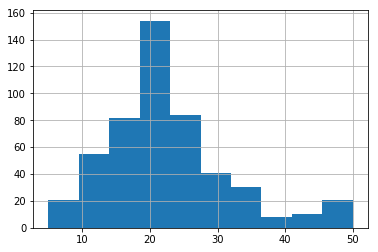

In [7]:
# np.log(boston_df['target']).hist()
boston_df['target'].hist()

#### Log of Response Variable

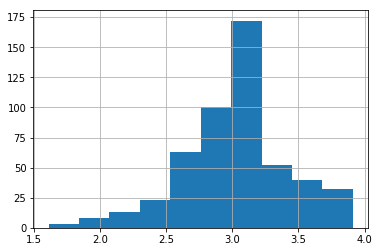

In [8]:
np.log(boston_df['target']).hist()

The log-transform of the response variable has a distribution much closer to normal. We'll create a log-target variable to see if it gives us better results.

In [9]:
boston_df['log_target'] = np.log(boston_df['target'])

## Splitting Data into Test and Train
Before fitting a predictive model, we'll split the data into train and test data sets. This can be done using the `sample` method from pandas, or the `train_test_split` method in scikit-learn.

In [10]:
train_data, test_data = train_test_split(boston_df, test_size = 0.2, random_state = 24)
print('Train length: {} \nTest Length: {}'.format(len(train_data), len(test_data)))

Train length: 404 
Test Length: 102


## Principal Components Analysis
Let's start with a PCA of this data. 

Here's an example in [Scikit-Learn](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html)

In [11]:
pca_unscaled = PCA(n_components=5)
pca_unscaled.fit(train_data.iloc[:,0:13])

# Throwing the components into a dataframe for easier viewing:
pd.DataFrame(pca_unscaled.components_, columns=boston_df.columns[0:13])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.026228,-0.047242,0.028402,-0.000048,0.000464,-0.001269,0.087663,-0.006854,0.044339,0.946034,0.005681,-0.301681,0.023435
1,0.007903,0.003434,-0.005164,-0.000113,0.000018,0.000664,-0.006384,0.000531,-0.009505,-0.302787,-0.002940,-0.952927,0.003016
2,-0.008844,0.637314,-0.088213,-0.001064,-0.001820,0.004587,-0.751707,0.044888,0.007625,0.098999,-0.007709,-0.024032,-0.091497
3,0.024533,0.764505,-0.008801,0.000904,0.000702,0.006172,0.641363,0.000993,-0.018597,-0.019871,-0.031893,0.005442,0.040971
4,0.742108,0.012940,-0.008041,-0.004809,-0.000087,-0.045043,-0.077646,0.007140,0.175906,-0.031470,0.051665,0.016841,0.637201


In [12]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(train_data.iloc[:,0:13])
X_test = X_scaler.transform(test_data.iloc[:,0:13])

pca_scaled = PCA(n_components=5)
pca_scaled.fit(X_train)

# Throwing the components into a dataframe for easier viewing:
pd.DataFrame(pca_scaled.components_, columns=boston_df.columns[0:13])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.268612,-0.254254,0.343348,0.006382,0.339347,-0.194932,0.311258,-0.319520,0.317596,0.340041,0.198058,-0.207057,0.307489
1,-0.287317,-0.279616,0.126474,0.470373,0.239156,0.204435,0.309355,-0.350665,-0.249273,-0.207574,-0.367623,0.188243,-0.092501
2,0.272327,0.326472,-0.046165,0.243163,0.084325,0.568979,-0.039080,-0.012770,0.305675,0.227389,-0.272019,-0.367498,-0.266953
3,0.009136,-0.022565,0.015896,0.724935,-0.169389,-0.074914,-0.165645,0.129899,0.204632,0.143371,0.484850,0.295650,-0.100452
4,0.140537,0.377696,0.013959,0.390362,0.080006,-0.499438,-0.056111,0.201711,-0.135724,-0.067917,-0.420580,-0.185586,0.388561


In [13]:
list(pca_scaled.explained_variance_ratio_)

[0.4770171492341357,
 0.1133582007768713,
 0.09601732783094474,
 0.06612588020095622,
 0.06222102502903388]

In [14]:
list(pca_unscaled.explained_variance_ratio_)

[0.80556360706161,
 0.16271528284577977,
 0.02182762745157756,
 0.007524745311693138,
 0.0008927977491543757]

## Linear Regression
Normally we'd next spend a good amount of time exploring the data for natural relationships, correlations, etc... However, for our purposes here, let's skip directly to fitting a linear regression model using all of the features in our dataset. Conveniently, all of the data is already numeric, so there is no data transformation required, other than normalization, which we've already done with the `StandardScaler`.

### Define Response Variable(s)

In [43]:
y_train =  train_data['target']
y_test = test_data['target']
y_train_log = train_data['log_target']
y_test_log = test_data['log_target']

### Fit Regression Model
* Using `statsmodels.api`
* Using `scikit-learn`

#### statsmodels.api

In [44]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     92.00
Date:                Fri, 05 Oct 2018   Prob (F-statistic):          5.06e-110
Time:                        14:10:45   Log-Likelihood:                -1195.3
No. Observations:                 404   AIC:                             2419.
Df Residuals:                     390   BIC:                             2475.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7248      0.236     96.228      0.0

In [68]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train_log, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             log_target   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     119.4
Date:                Fri, 05 Oct 2018   Prob (F-statistic):          4.76e-127
Time:                        14:28:56   Log-Likelihood:                 107.65
No. Observations:                 404   AIC:                            -187.3
Df Residuals:                     390   BIC:                            -131.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0407      0.009    323.947      0.0

#### scikit-learn

In [51]:
# Create linear regression object
regr1 = linear_model.LinearRegression()

# Train the model using the training sets
regr1.fit(X_train, y_train)

# Make predictions
y_pred_train = regr1.predict(X_train)
y_pred_test = regr1.predict(X_test)

# The coefficients
print('Coefficients: \n', regr1.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred_test))
# Explained variance score: 1 is perfect prediction
print('Train variance score: %.2f' % r2_score(y_train, y_pred_train))
print('Test variance score: %.2f' % r2_score(y_test, y_pred_test))

Coefficients: 
 [-0.38768528  1.01967098 -0.0215033   0.82462967 -1.76524459  3.11720791
 -0.17115482 -3.05354928  2.21452555 -2.02483947 -1.84103466  1.01244466
 -3.63606954]
Mean squared error: 23.69
Train variance score: 0.75
Test variance score: 0.65


There is apparently not a similar report to the one from the statsmodels.api. However we can reproduce the table with p-values as done in this post on [Stackoverflow](https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression).

In [61]:
def regression_report(X, y, model):
    params = np.append(model.intercept_,model.coef_)
    predictions = model.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    R2 = r2_score(y, predictions)

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    summary_df = pd.DataFrame()
    summary_df["Coefficients"],summary_df["Standard Errors"],summary_df["t values"],summary_df["Probabilites"] = [params,sd_b,ts_b,p_values]
    report = {'r2': R2, 'mse': MSE, 'summary': summary_df }
    return(report)

In [62]:
regression_report(X_train, y_train, regr1)

{'r2': 0.7540976665084576,
 'mse': 22.53062632158762,
 'summary':     Coefficients  Standard Errors  t values  Probabilites
 0        22.7248            0.236    96.228         0.000
 1        -0.3877            0.343    -1.129         0.259
 2         1.0197            0.353     2.885         0.004
 3        -0.0215            0.473    -0.045         0.964
 4         0.8246            0.246     3.358         0.001
 5        -1.7652            0.498    -3.545         0.000
 6         3.1172            0.337     9.260         0.000
 7        -0.1712            0.420    -0.407         0.684
 8        -3.0535            0.475    -6.425         0.000
 9         2.2145            0.649     3.410         0.001
 10       -2.0248            0.705    -2.872         0.004
 11       -1.8410            0.319    -5.770         0.000
 12        1.0124            0.279     3.624         0.000
 13       -3.6361            0.405    -8.975         0.000}

### Fit Regression to log-response

In [63]:
# Create linear regression object
regr2 = linear_model.LinearRegression()

# Train the model using the training sets
regr2.fit(X_train, Y_train_log)

# Make predictions 
Y_pred_log_train = regr2.predict(X_train)
Y_pred_log_test = regr2.predict(X_test)

# The coefficients
print('Coefficients: \n', regr2.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test_log, Y_pred_log_test))
# Explained variance score: 1 is perfect prediction
print('Train variance score: %.2f' % r2_score(Y_train_log, Y_pred_log_train))
print('Test variance score: %.2f' % r2_score(Y_test_log, Y_pred_log_test))

Coefficients: 
 [-0.0682741   0.02557869  0.01015132  0.02974944 -0.07871488  0.07175371
  0.00399925 -0.09980754  0.11318973 -0.10975732 -0.07381239  0.0379177
 -0.21234728]
Mean squared error: 0.04
Train variance score: 0.80
Test variance score: 0.74


In [65]:
regression_report(X_train, Y_train_log, regr2)

{'r2': 0.7992106882401949,
 'mse': 0.035594981557699336,
 'summary':     Coefficients  Standard Errors  t values  Probabilites
 0         3.0407            0.009   323.947         0.000
 1        -0.0683            0.014    -5.004         0.000
 2         0.0256            0.014     1.821         0.069
 3         0.0102            0.019     0.540         0.589
 4         0.0297            0.010     3.048         0.002
 5        -0.0787            0.020    -3.977         0.000
 6         0.0718            0.013     5.363         0.000
 7         0.0040            0.017     0.239         0.811
 8        -0.0998            0.019    -5.283         0.000
 9         0.1132            0.026     4.385         0.000
 10       -0.1098            0.028    -3.916         0.000
 11       -0.0738            0.013    -5.820         0.000
 12        0.0379            0.011     3.415         0.001
 13       -0.2123            0.016   -13.187         0.000}

## Classifier Models
Next let's look at a classifier model using our classified life-event tweets. We'll create a classifier based on the vocabulary of the tweets. So far we've only created binary classifiers, since the tweet data has been gathered by tweet topic. However, since we have a dataset with multiple tweet categories classified, we'll create a multi-class classifier model.

### Load data

In [64]:
filename = 'sample_data.xlsx'
t_data = pd.read_excel(filename, sheet_name='tweets_classified')
t_data.head()

,text,class,topic
0,You remind me of my BimmerSee your ignition b...,0,Birth
1,RT @JaDineNATION: Were so excited for our dese...,0,Birth
2,i always get super self conscious about keepin...,0,Birth
3,@Juhhhhhhnelle Weird ass bitch lucky Im pregna...,1,Birth
4,RT @thdmichaelbell: New Signage above our Fron...,0,Birth


Before extracting the vocabulary from these texts, the data needs a little cleaning to remove some noise. Here's what we'll do:
1. Convert everything to lower case
1. Remove hyperlinks
1. Stemming - cutting words down to their roots

In [19]:
t_data['mod_text'] = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',
                    str(x).lower()) for x in t_data['text']]
t_data.head()

,text,class,topic,mod_text
0,You remind me of my BimmerSee your ignition b...,0,Birth,you remind me of my bimmersee your ignition b...
1,RT @JaDineNATION: Were so excited for our dese...,0,Birth,rt @jadinenation: were so excited for our dese...
2,i always get super self conscious about keepin...,0,Birth,i always get super self conscious about keepin...
3,@Juhhhhhhnelle Weird ass bitch lucky Im pregna...,1,Birth,@juhhhhhhnelle weird ass bitch lucky im pregna...
4,RT @thdmichaelbell: New Signage above our Fron...,0,Birth,rt @thdmichaelbell: new signage above our fron...


## Split into train/test

In [20]:
t_train, t_test = train_test_split(t_data, test_size = 0.2, random_state = 24)
print('Train length: {} \nTest Length: {}'.format(len(t_train), len(t_test)))

Train length: 905 
Test Length: 227


### Word Count Vectorizer
Now that we've 'cleaned' our data, we need to transform it into a vocabulary of words that becomes our feature matrix for scikit-learn. We'll use the `CountVectorizer` from scikit-learn along with the `SnowballStemmer` from `nltk` (natural language tool kit) to create our feature vectors.

In [21]:
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.  
# vectorizer = CountVectorizer(min_df=10, stop_words=stop_words, ngram_range=(1,2))

# fit_transform() does two functions: First, it fits the model and learns the vocabulary;
# second, it transforms our training data into feature vectors. 
# The input to fit_transform should be a list of strings.

#creating the custom, stemmed count vectorizer
english_stemmer = SnowballStemmer('english')
stop_words = text.ENGLISH_STOP_WORDS
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

vectorizer_s = StemmedCountVectorizer(min_df=5, analyzer="word", stop_words=stop_words)

In [22]:
# Create the feature vectors for all of the different data sets.
train_data_features = vectorizer_s.fit_transform(t_train['mod_text'])
test_data_features = vectorizer_s.transform(t_test['mod_text'])
word_features = vectorizer_s.get_feature_names()

Let's see what words are used most frequently. Looking at the top 20 words:

In [23]:
word_counts = train_data_features.sum(axis = 0)
word_count_df = pd.DataFrame(word_features)
word_count_df['count'] = word_counts[0,:].tolist()[0]
word_count_df.columns = ['word','count']
word_count_df.sort_values(by = 'count', ascending = False).head(20)

,word,count
227,wed,188
92,graduat,187
57,divorc,178
147,new,166
12,babi,117
104,home,117
176,rt,112
145,move,83
130,love,70
84,girl,62


## Response variable
We are trying to predict the topic that each tweet belongs to. Since we have multiple topics represented, this becomes a multi-class classification problem. Let's look at the value counts for our different topics.

In [24]:
t_data.topic.value_counts()

Marriage      241
Moving        240
Graduation    226
Divorce       226
Birth         199
Name: topic, dtype: int64

To make these text labels into targets that scikit-learn can work with, we need to transform them into binary varialbes. We can use the Scikit-learn "LabelBinarizer" to simplify that for us.

In [25]:
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(train_data_features, t_train.topic) 
train_predictions = svm_model_linear.predict(train_data_features) 
test_predictions = svm_model_linear.predict(test_data_features) 
  
# model accuracy for X_test   
train_accuracy = svm_model_linear.score(train_data_features, t_train.topic) 
test_accuracy = svm_model_linear.score(test_data_features, t_test.topic) 
print('Train accuracy: {:0.4f} \nTest accuracy: {:0.4f}'.format(train_accuracy, test_accuracy))
  
# creating a confusion matrix 
cm = confusion_matrix(t_test.topic, test_predictions) 
cm

Train accuracy: 0.9945 
Test accuracy: 0.9648


array([[37,  0,  0,  0,  1],
       [ 0, 41,  0,  1,  0],
       [ 2,  0, 48,  0,  1],
       [ 0,  1,  0, 45,  0],
       [ 1,  1,  0,  0, 48]], dtype=int64)

In [26]:
t_test.topic.value_counts()

Graduation    51
Moving        50
Marriage      46
Divorce       42
Birth         38
Name: topic, dtype: int64

In [29]:
t_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 503 to 42
Data columns (total 4 columns):
text        227 non-null object
class       227 non-null int64
topic       227 non-null object
mod_text    227 non-null object
dtypes: int64(1), object(3)
memory usage: 8.9+ KB


### Eigenvalues

In [2]:
from numpy.linalg import eig

In [3]:
a = np.array([[1, 3], [2, 4]])
a

array([[1, 3],
       [2, 4]])

In [4]:
eig(a)

(array([-0.37228132,  5.37228132]), array([[-0.90937671, -0.56576746],
        [ 0.41597356, -0.82456484]]))

In [5]:
from numpy.linalg import eig
a = np.array([[1, 3], [2, 4]])
eigen = eig(a)
print('Eigen values: {} '.format(eigen[0]))
print('Eigen vectors: {} '.format(eigen[1]))

Eigen values: [-0.37228132  5.37228132] 
Eigen vectors: [[-0.90937671 -0.56576746]
 [ 0.41597356 -0.82456484]] 


In [19]:
eigen

(array([-0.37228132,  5.37228132]), array([[-0.90937671, -0.56576746],
        [ 0.41597356, -0.82456484]]))

In [25]:
for i in eigen:
    print('{}, {}'.format(type(i), i.shape()))

TypeError: 'tuple' object is not callable